Qiwen Hu, Ivan Schwieger, Ben Trey<br>
APM115: Mathematical Modeling<br>
Workshop Report<br>
3/1/2021<br>

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.integrate import solve_ivp

<b>Workshop	on	models	of	an	epidemic</b><br><br>
The classic model of an epidemic focuses on populations of individuals: those who are
Susceptible to infection with a disease, those who are Infected and are infectious with the
disease and those who have Recovered from the disease and are immune to further
infection. The classic model is really a family of models called “SIR models” after
Kermack and McKendrick (1927)<sup>1</sup><br><br>
The sizes of the populations of susceptible (S), infected (I), and recovered (R) individuals
are the variables of the model. We will assume they are related by the transitions:<br><br>
S → I at a rate proportional to I. The rate constant depends on the frequency of
interpersonal contacts and the ease with which the pathogen is transmitted.<br><br>
I → R at a rate dependent on the clearance of the pathogen from a typical individual.<br>
The task of this workshop is to model the system using the continuous deterministic
approach, the stochastic probability distribution approach, and an individual agent
approach.

<b> Question 1.</b> For the continuous deterministic approach, we can describe our model as a system of
ODEs:
$${ \frac{dS}{dt} = -\frac{a}{N} I S \\ \frac{dI}{dt} = \frac{a}{N} I S - b I \\ \frac{dR}{dt} = b I}$$

where	$N=S(t)+I(t)+R(t)$	is	the	total	population.
Use ode45 to solve this system. Let us use a=2ln(2)/week so that the initial doubling time
of the infected is 1 week and b=ln(2)/week so that the half life of an infected state is one
week as well. Use the following initial condition: S=999; I=1; R=0; (hence N=1000), and
integrate over t=[0 20] in unit of weeks;<br><br>
Think about how you may understand the qualitative behavior of the solution. For
example, what do you expect the initial growth of the infected to be? And at what
population of the Susceptible do you expect the number of the Infected to decrease? The
latter result, known as herd immunity, forms the basis of a general theory of vaccination
policy.<br><br>


<b>Answer 1:</b> The initial value of $S$ is $N$ making the initial growth rate $\frac{dI}{dt} = \left(\frac{a}{N} S-b\right) I$. The amount of infected should decrease when $\frac{dI}{dt} = 0 \implies S = \frac{b N}{a}$. In the graph below $ S = 500$ when $\frac{dI}{dt} =0 $. 

In [2]:
# the following defines the function on the right hand side of the ODE to be integrated 
def f(a, b, N):
    return lambda t, y : np.array([-a/N*y[1]*y[0], a/N*y[1]*y[0]-b*y[1], b*y[1]])

In [3]:
# initial condition
y0 = np.array([999,1,0])           

# integrate using solve_ivp
sir = solve_ivp(f(2*np.log(2), np.log(2), 1000), [0, 20], y0, max_step = 1.)

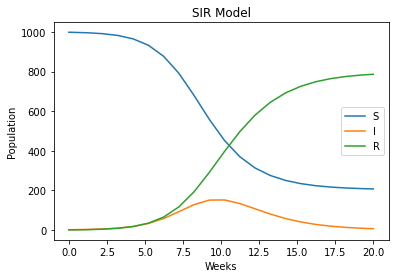

In [4]:
# plot results
plt.plot(sir.t, sir.y[0, :], label="S")
plt.plot(sir.t, sir.y[1, :], label="I")
plt.plot(sir.t, sir.y[2, :], label="R")
plt.legend()
plt.title('SIR Model')
plt.xlabel('Weeks')
plt.ylabel('Population')
plt.show()

<b>Question 1: (cont)</b>The value a/b is known as the basic reproduction number or R<sub>0</sub> and can be interpreted as
the number of people an infected individual can infect before s/he recovers without
immunity and intervention. Our choices of a=2ln(2)/week and b=ln(2)/week give a R<sub>0</sub> of
2, broadly suitable for the seasonal influenza. For COVID-19, R<sub>0</sub> is estimated to be
between 2 and 3 (again without social distancing)2, and some new variants of the virus
are found to have R<sub>0</sub> values 50% higher. Hold the value of b the same, change a to
produce different R<sub>0</sub> values to explore its effect. 

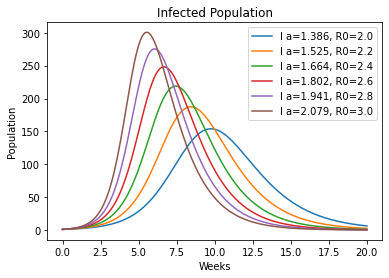

In [5]:
for a in np.arange(1.0, 1.51, 0.1)*2*np.log(2):
    # integrate using solve_ivp
    sol = solve_ivp(f(a, np.log(2), 1000), [0, 20], y0, max_step = 0.1)
    plt.plot(sol.t, sol.y[1, :], label="I a="+str(round(a,3))+", R0="+str(round(a/np.log(2),3)))
plt.legend()
plt.title('Infected Population')
plt.xlabel('Weeks')
plt.ylabel('Population')
plt.show()


<b>Question 2.</b> Follow what we did for the probabilistic population model, consider the conditional
probability of the populations of Susceptible and Infected at time t+h given their
populations at time t for a time interval h small enough that only one infection or
recovery event can happen. Modify the code that we used in that class and in HW#2 to
model the epidemic. This is often called the Reed-Frost model.<br><br>
To start, figure out what should the probability of having an event per unit time be for the
probabilistic model to be consistent with the continuous deterministic model in the limit
of large population. Also note that $S\rightarrow S-1$ and $I\rightarrow I+1$ are the same event and need to be
determined by the same random number. The same is true for $I\rightarrow I-1$ and $R \rightarrow R+1$. In
fact, like in the stochastic population model discussed in class, you can use the same
random number and three buckets to determine how the infected population will evolve
and determine the evolution of the other two categories by consistency.

<b>Answer 2:</b>

In [6]:
def ReedFrost(a,b,N,dt):
    
    #create array of time
    t =np.arange(0,20,dt)
    
    #create array of sir populations and set initial
    sir = np.zeros((3,t.size), dtype=int)
    sir[:,0] = [N-int(0.01*N), int(0.01*N), 0]
    
    #simiulate remaining time steps
    for n in range(1,t.size):
        
        #probabilities from SIR model 
        ps = a*sir[1,n-1]/N*dt
        pr = b*dt
        
        #these are a vectorized for loops
        ds = sum(np.random.rand(sir[0,n-1])<ps)
        dr = sum(np.random.rand(sir[1,n-1])<pr)
        
        #update sir populations
        sir[0,n] = sir[0,n-1] - ds
        sir[1,n] = sir[1,n-1] + ds - dr
        sir[2,n] = sir[2,n-1] + dr
        
    return t, sir

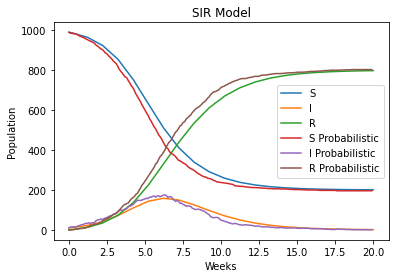

In [11]:
y0 = np.array([990,10,0])           

sirs = ReedFrost(2*np.log(2),np.log(2),1000, .1)
sir = solve_ivp(f(2*np.log(2), np.log(2), 1000), [0, 20], y0, max_step = 1.)

# plot results
plt.plot(sir.t, sir.y[0, :], label="S")
plt.plot(sir.t, sir.y[1, :], label="I")
plt.plot(sir.t, sir.y[2, :], label="R")
plt.plot(sirs[0], sirs[1][0, :], label="S Probabilistic")
plt.plot(sirs[0], sirs[1][1, :], label="I Probabilistic")
plt.plot(sirs[0], sirs[1][2, :], label="R Probabilistic")
plt.legend()
plt.title('SIR Model')
plt.xlabel('Weeks')
plt.ylabel('Population')
plt.show()

<b>Question 3:</b> Check consistency between the deterministic and the probabilistic approaches.


<b>Answer 3:</b> We used a very large population for the probabilistic model and the previous result to check for consistency. Each method is normalized and shown below.  

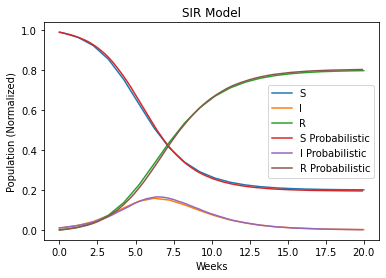

In [8]:
sirs = ReedFrost(2*np.log(2),np.log(2),100000, .1)
sir = solve_ivp(f(2*np.log(2), np.log(2), 1000), [0, 20], y0, max_step = 1.)

# plot results
plt.plot(sir.t, sir.y[0, :]/1000, label="S")
plt.plot(sir.t, sir.y[1, :]/1000, label="I")
plt.plot(sir.t, sir.y[2, :]/1000, label="R")
plt.plot(sirs[0], sirs[1][0, :]/100000, label="S Probabilistic")
plt.plot(sirs[0], sirs[1][1, :]/100000, label="I Probabilistic")
plt.plot(sirs[0], sirs[1][2, :]/100000, label="R Probabilistic")
plt.legend()
plt.title('SIR Model')
plt.xlabel('Weeks')
plt.ylabel('Population (Normalized)')
plt.show()

<b>Question 4:</b> We can also model the spread of infectious diseases by representing each individual in
the population explicitly. A separate discussion of the individual agent model is on the
course webpage, along with the codes. Use them to model the epidemic as well. 

In [9]:
class agent:
    
    def __init__ (self):
        self.status = 's'
    
    def infect(self):
        if self.status == 's':
            self.status = 'i'
    
    def recover(self):
        if self.status == 'i':
            self.status = 'r'

            
def census(population):
    
    #create an array of statuses
    statuses = np.array([individual.status for individual in population])

    #vectorized for loops counting statuses 
    s = np.sum(statuses == 's')
    i = np.sum(statuses == 'i')
    r = np.sum(statuses == 'r')
    
    return np.array([s, i, r])


def epidemic1D(nc,pt,population):

    N = population.size
    
    for n in range(N):
        
        #check if the indidual is infected
        if population[n].status=='i':
            
            #create a random list of others with the individual removed
            others = np.delete(np.arange(N),n)
            indices = np.random.choice(others,nc,replace=False)
            
            #infect the susceptible others with a certain probability
            for index in indices:
                indicies = np.random.rand()
                if np.random.rand()<pt:
                    population[index].infect()
                    
            #put the infected individual in the recovered state
            population[n].recover()
            
    return population
            

def simulate1D(nc,pt,N):
    
    #list of the sir populations by week
    sir = []
    
    #creates an array of the class agent
    population = np.array([agent() for n in range(N)])
    
    #randomly infect 10 percent
    indices = np.random.choice(np.arange(N),N//100,replace=False)
    for index in indices:
        population[index].infect()
        
    #record initial populations
    state = census(population)
    sir.append(state)
    
    #simulate the remaining weeks
    while state[1]>0:
        new_population=epidemic1D(nc,pt,population)
        state = census(new_population)
        sir.append(state)
        population = new_population
        
    return np.array(sir).T

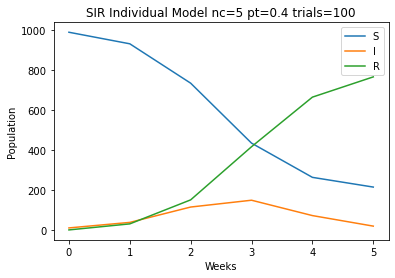

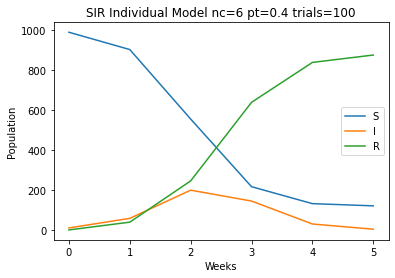

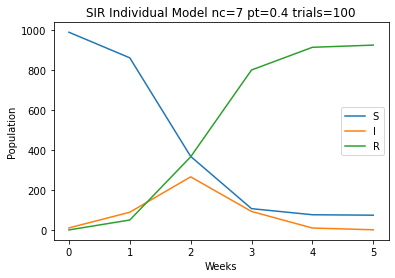

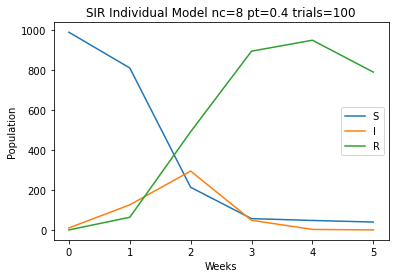

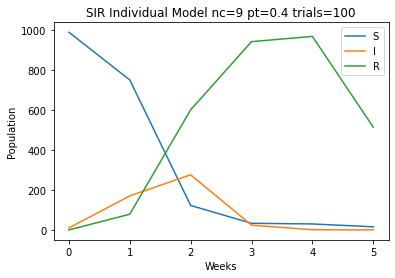

In [93]:
# plot results
pt = 0.4
N = 1000
trials = 100
for nc in range(5,10):
    sir = np.zeros((3,1), dtype=float)
    for n in range(trials):
        trial = simulate1D(nc,pt,N)/trials
        while sir.shape[1]<trial.shape[1]:
            sir = np.append(sir.T,np.array([[0,0,0]]),axis=0).T
        while trial.shape[1]<sir.shape[1]:
            trial = np.append(trial.T,np.array([[0,0,0]]),axis=0).T
        sir += trial
    weeks = np.arange(0,sir.shape[1],1)[:6]
    plt.plot(weeks, sir[0, :][:6], label="S")
    plt.plot(weeks, sir[1, :][:6], label="I")
    plt.plot(weeks, sir[2, :][:6], label="R") 
    plt.legend()
    plt.title('SIR Individual Model nc='+str(nc)+' pt='+str(pt)+' trials='+str(trials))
    plt.xlabel('Weeks')
    plt.ylabel('Population')
    plt.show()

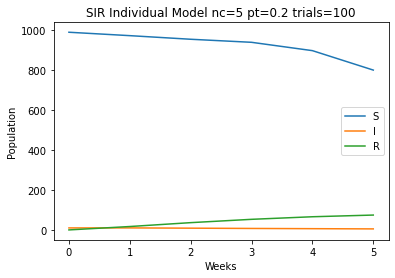

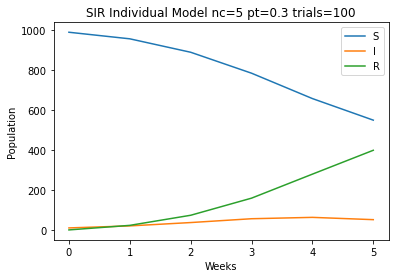

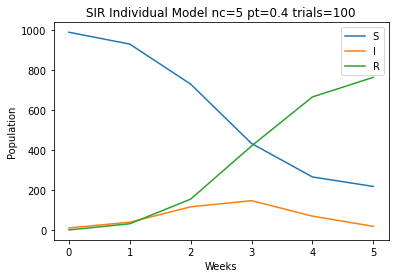

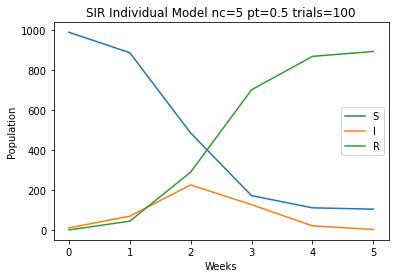

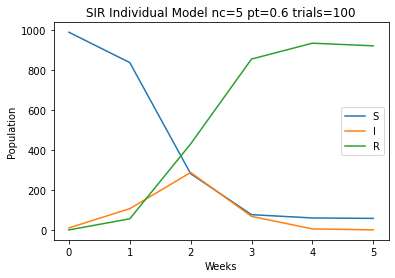

In [95]:
# plot results
nc=5
N = 1000
trials = 100
for pt in np.arange(0.2,0.7,0.1):
    sir = np.zeros((3,1), dtype=float)
    for n in range(trials):
        trial = simulate1D(nc,pt,N)/trials
        while sir.shape[1]<trial.shape[1]:
            sir = np.append(sir.T,np.array([[0,0,0]]),axis=0).T
        while trial.shape[1]<sir.shape[1]:
            trial = np.append(trial.T,np.array([[0,0,0]]),axis=0).T
        sir += trial
    weeks = np.arange(0,sir.shape[1],1)[:6]
    plt.plot(weeks, sir[0, :][:6], label="S")
    plt.plot(weeks, sir[1, :][:6], label="I")
    plt.plot(weeks, sir[2, :][:6], label="R") 
    plt.legend()
    plt.title('SIR Individual Model nc='+str(nc)+' pt='+str(round(pt,2))+' trials='+str(trials))
    plt.xlabel('Weeks')
    plt.ylabel('Population')
    plt.show()

<b>Question 5:</b> Discuss the pros and cons of the different approaches

<b>Answer 5:</b>The first method is deterministic while the last two are only deterministic after setting a seed. The first method would give a definitive answer for behavior of the system while the last two would give distributions. In some cases definitive answers are better but distributions give an ability to manage risk. As we showed the second method replicates the first method very well.<br><br>
The first two methods allow for a space complexity much smaller than the size of the population used. As the third method requires and object to represent each individual its space complexity is by necessity the size of the population. This will reduce the size of the population the third method can model.<br><br>
The first method gives a time complexity proportional to the number of steps. The second and third methods take a little longer as they need to generate random numbers for certain individuals. Its time complexity would be the product of the time steps and the population.<br><br>
The first two methods treat the individuals as identical. The third method allows parameters to represent the behavior of individuals. In the third method I created a class in anticipation of giving them additional parameters to the individuals.<br><br> 
In the end of the day on-demand resources make the concerns of space and time complexity irrelevant. The first method allows to create a public policy due to its clear parameters. The third method allows for the modeling of the individual. This would create better public policy for the behavior of the individual.


<b>Quesion 6:</b> Make a list of the different ways that mathematical modeling is used in the fight
against the COVID-19 pandemic.

<b>Answer 6:</b> <br>-Determining the conditions for heard imunity<br>-Comparing the effectiveness of policy<br>-Contact tracing<br>-Predicting the number of infected to allocate resources<br>-Determing if herd immunity can be reached